<a href="https://colab.research.google.com/github/KostyaKrechetov/Data-analysis-course-ITMO/blob/main/Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
pip install --upgrade scipy

Requirement already up-to-date: scipy in /usr/local/lib/python3.7/dist-packages (1.6.2)


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## *Step 1* 
Choosing a subsample with main variables for further analysis.

In [5]:
# Import data from csv file - Spotify Dataset

path_to_file = '/content/drive/MyDrive/Colab Notebooks/kaggle_dataset/data.csv'
source_df = pd.read_csv(path_to_file, engine='python')

source_df.sample(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
165230,0.884,['Dr. Hook'],0.498,226653,0.389,0,2ditzwbFRlNsvJ3tlUnNx8,0.040900,3,0.0807,-11.444,1,More Like The Movies,28,1976-06-04,0.0276,106.364,0.475,1976
106231,0.242,['Intocable'],0.429,219600,0.576,0,6BTtKitErY2JcpwdZ9rdpZ,0.000001,9,0.1870,-10.592,0,El Amigo Que Se Fué,49,1999-01-01,0.2350,187.566,0.883,1999
155942,0.300,"['El Gran Combo De Puerto Rico', 'Gilberto San...",0.682,205493,0.797,0,2dCDoaZcfidSCEtPxNbMco,0.080100,0,0.1050,-4.594,0,Aunque Me Pidas Perdon,2,2008-08-05,0.0369,104.552,0.974,2008
112882,0.990,"['Modest Mussorgsky', 'Vladimir Horowitz']",0.630,155627,0.130,0,1t1j3uEeutppxJnWRPj95a,0.878000,4,0.1130,-15.041,1,Pictures at an Exhibition: 4. Bydlo,0,1951,0.0699,105.299,0.283,1951
64233,0.729,['Martin Denny'],0.207,189907,0.600,0,5uCtZvALkIwZHJkKaMV15Z,0.000204,2,0.1460,-8.548,0,Hypnotique,16,1958-01-01,0.0331,74.128,0.114,1958


In [6]:
source_df.shape

(174389, 19)

In [7]:
# Selecting subsample with 4 random variables
RVs = ['danceability', 'loudness', 'tempo', 'duration_ms']
source_df = source_df[RVs]
source_df.describe()

,danceability,loudness,tempo,duration_ms
count,174389.000000,174389.000000,174389.000000,1.743890e+05
mean,0.536758,-11.750865,117.006500,2.328100e+05
std,0.176025,5.691591,30.254178,1.483958e+05
min,0.000000,-60.000000,0.000000,4.937000e+03
25%,0.414000,-14.908000,93.931000,1.661330e+05
50%,0.548000,-10.836000,115.816000,2.057870e+05
75%,0.669000,-7.499000,135.011000,2.657200e+05
max,0.988000,3.855000,243.507000,5.338302e+06


In [8]:
source_df.dropna(how='any', inplace=True)
source_df.shape

(174389, 4)

There are no NaN values in Dataframe

## Step 2 - 3
2. A non-parametric estimation of PDF in form of histogram and using kernel density function (KDE).
3. An estimation of order statistics and represent them as “box with whiskers” plot.

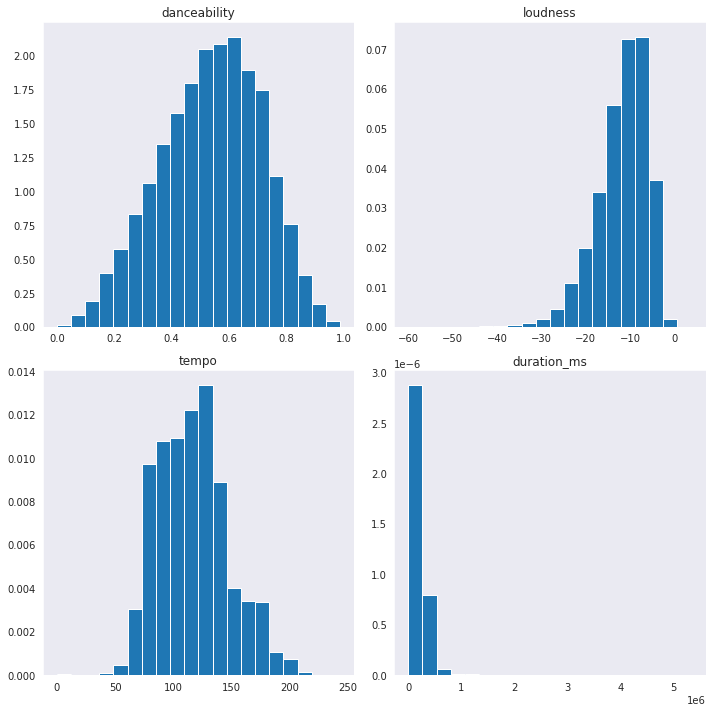

In [9]:
sns.set_style('darkgrid')
source_df.hist(density=True, sharex=False, sharey=False, grid=False, figsize=(10, 10), bins=20)
plt.tight_layout()

Trimming the data for 'duration_ms' to remove the tail/outliers.

In [10]:
def trim(data, procentile):
    data_trim = data[data < np.percentile(data, procentile)].dropna()
    print(f'There was deleted {data[data > np.percentile(data,procentile)].shape[0]} ({data[data > np.percentile(data,procentile)].shape[0] / data.shape[0] * 100:.1f}%)')
    return data_trim

source_df.duration_ms = trim(source_df.duration_ms, 99)

There was deleted 1744 (1.0%)


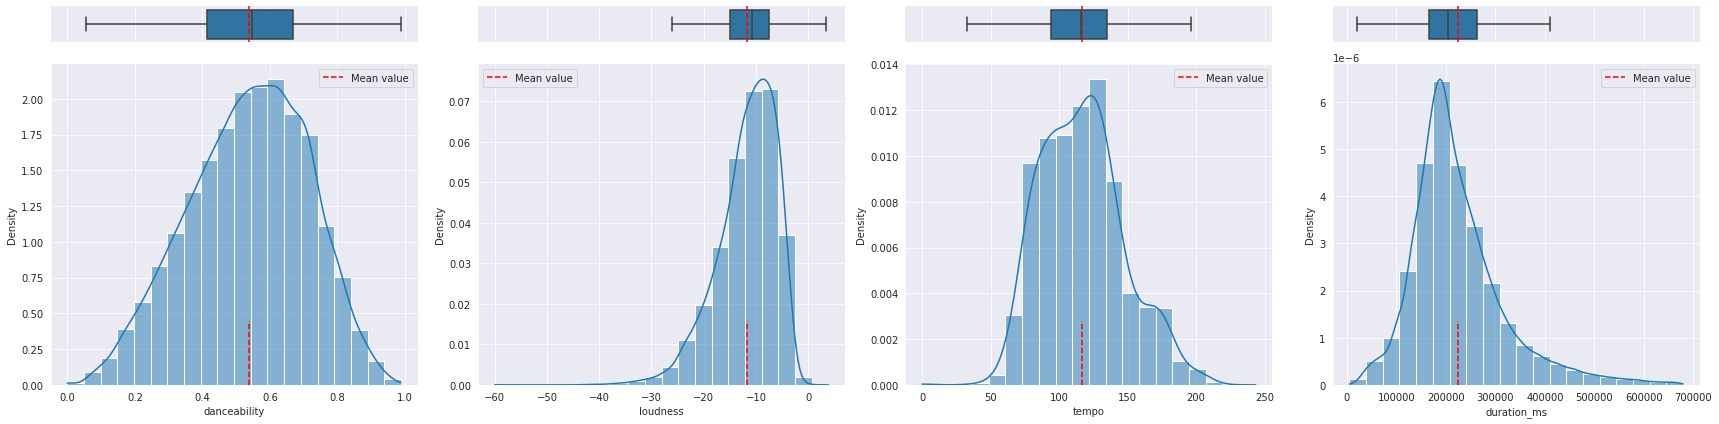

In [11]:
sns.set_style('darkgrid')

f, axs = plt.subplots(2, 4, gridspec_kw={"height_ratios": (.1, .9)}, sharex='col', figsize=(24, 6))
bw_adjust = [1.5, 1.5, 3, 1.2] # Bandwidth for Kernel Density Function. Adjusting smoothness

for ind, RV in enumerate(RVs):
    x = source_df[RV]
    ax_box = axs[0][ind]
    ax_dist = axs[1][ind]
    
    sns.boxplot(x, ax=ax_box, showfliers=False)
    sns.histplot(data=x, bins=20, kde=True, kde_kws={'bw_adjust': bw_adjust[ind]}, stat='density', ax=ax_dist)
    ax_dist.axvline(x=x.mean(), color='r', ymax=0.2, linestyle='--', label='Mean value')
    ax_box.axvline(x=x.mean(), color='r', ymax=1, linestyle='--', label='Mean value')

    plt.setp(ax_box, xlabel='')
    ax_box.set(yticks=[])
    ax_dist.legend()
    sns.despine(ax=ax_dist)
    sns.despine(ax=ax_box, left=True)
    
plt.tight_layout()

## Step 4 - 7 

Selecting and estimating best theoretical distribution to fit our data

#### Maximum Likelihood Method (MLE)

In [12]:
# Theoretical distributions to fit
DISTRIBUTIONS = [        
    stats.beta,
    stats.dgamma,
    stats.expon,
    stats.exponnorm,
    stats.exponpow,
    stats.gamma,
    stats.gilbrat,
    stats.johnsonsb,
    stats.laplace,
    stats.levy, 
    stats.logistic,
    stats.loggamma,
    stats.lognorm,
    stats.mielke,
    stats.norm,
    stats.pareto,
    stats.pearson3,
    stats.powerlaw,
    stats.rice,
    stats.skewnorm,
    stats.t,
    stats.triang,
    stats.vonmises,
    stats.weibull_min,
    stats.weibull_max,
]

In [13]:
def find_distribution(data, bins=100):
    """Finding best fit distribution to data"""
    # Get histogram of original data
    data = data.dropna()
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    # Getting the middles of the each histogram interval
    x = (bin_edges + np.roll(bin_edges, -1))[:-1] / 2.0
    y = hist
    
    # Best holders
    best_distribution = stats.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        
        # Try to fit the distribution
        try:
            # fit dist to data
            params = distribution.fit(data)

            # Separate parts of parameters
            arg = params[:-2]
            loc = params[-2]
            scale = params[-1]

            # Calculate fitted PDF and error with fit in distribution
            pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
            sse = np.sum(np.power(y - pdf, 2.0))

            # identify if this distribution is better
            if best_sse > sse > 0:
                best_distribution = distribution
                best_params = params
                best_sse = sse
                print(f'\t{best_distribution.name}: SSE={round(sse, 1)}')
        except Exception:
            pass

    return (best_distribution, best_params)


In [14]:
MLE_dists = []
MLE_fit_params = []

# Comparing all theoretical distributions and selecting the best one
for RV in RVs:
    print(f'{RV}:')
    dist, params = find_distribution(source_df[RV], 100)
    MLE_dists.append(dist)
    MLE_fit_params.append(params)
    dist_name = dist.name
    print(f"The best distribution for {RV} is:", dist_name)

danceability:
	beta: SSE=1.0
	exponpow: SSE=0.8
The best distribution for danceability is: exponpow
loudness:
	beta: SSE=0.1
	dgamma: SSE=0.0
	exponnorm: SSE=0.0
	johnsonsb: SSE=0.0
	skewnorm: SSE=0.0
The best distribution for loudness is: skewnorm
tempo:
	beta: SSE=0.0
	weibull_max: SSE=0.0
The best distribution for tempo is: weibull_max
duration_ms:
	beta: SSE=0.0
	dgamma: SSE=0.0
	exponnorm: SSE=0.0
The best distribution for duration_ms is: exponnorm


#### Least-squares method

In [15]:
# Defining funcs that calculate percentiles for each distribution. Used for optimization.

def func_exponpow(x, b, loc, scale):
    return stats.exponpow.ppf(x / 100.0, b, loc, scale)

def func_mielke(x, k, s, loc, scale):
    return stats.mielke.ppf(x / 100.0, k, s, loc, scale)

def func_skewnorm(x, a, loc, scale):
    return stats.skewnorm.ppf(x / 100.0, a, loc, scale)

def func_weibull_max(x, c, loc, scale):
    return stats.weibull_max.ppf(x / 100.0, c, loc, scale)

def func_exponnorm(x, k, loc, scale):
    return stats.exponnorm.ppf(x / 100.0, k, loc, scale)

In [16]:
from scipy.optimize import curve_fit

qn_empir = []
LS_fit_params = []
percs = np.linspace(1, 99, 99)


# RV: danceability
qn_empir.append(np.percentile(source_df[RVs[0]], percs))
popt, pcov = curve_fit(func_exponpow, xdata=percs, ydata=np.percentile(source_df[RVs[0]], percs))
LS_fit_params.append(popt)


# RV: loudness
qn_empir.append(np.percentile(source_df[RVs[1]], percs))
popt, pcov = curve_fit(func_skewnorm, xdata=percs, ydata=np.percentile(source_df[RVs[1]], percs))
LS_fit_params.append(popt)


# RV: tempo
qn_empir.append(np.percentile(source_df[RVs[2]], percs))
popt, pcov = curve_fit(func_weibull_max, xdata=percs, ydata=np.percentile(source_df[RVs[2]], percs))
LS_fit_params.append(popt)


# RV: duration_ms
qn_empir.append(np.percentile(source_df[RVs[3]].dropna(), percs))
popt, pcov = curve_fit(func_exponnorm, xdata=percs, ydata=np.percentile(source_df[RVs[3]].dropna(), percs))
LS_fit_params.append(popt)

print(LS_fit_params)

[array([2.3626984 , 0.04029688, 0.66703494]), array([-5.21611498, -4.62858525,  9.06932402]), array([  7.57538017, 311.88917176, 207.39353961]), array([2.07811717e+00, 1.38125617e+05, 4.13988602e+04])]


#### Plotting a quantile biplot for empirical and theoretical distributions

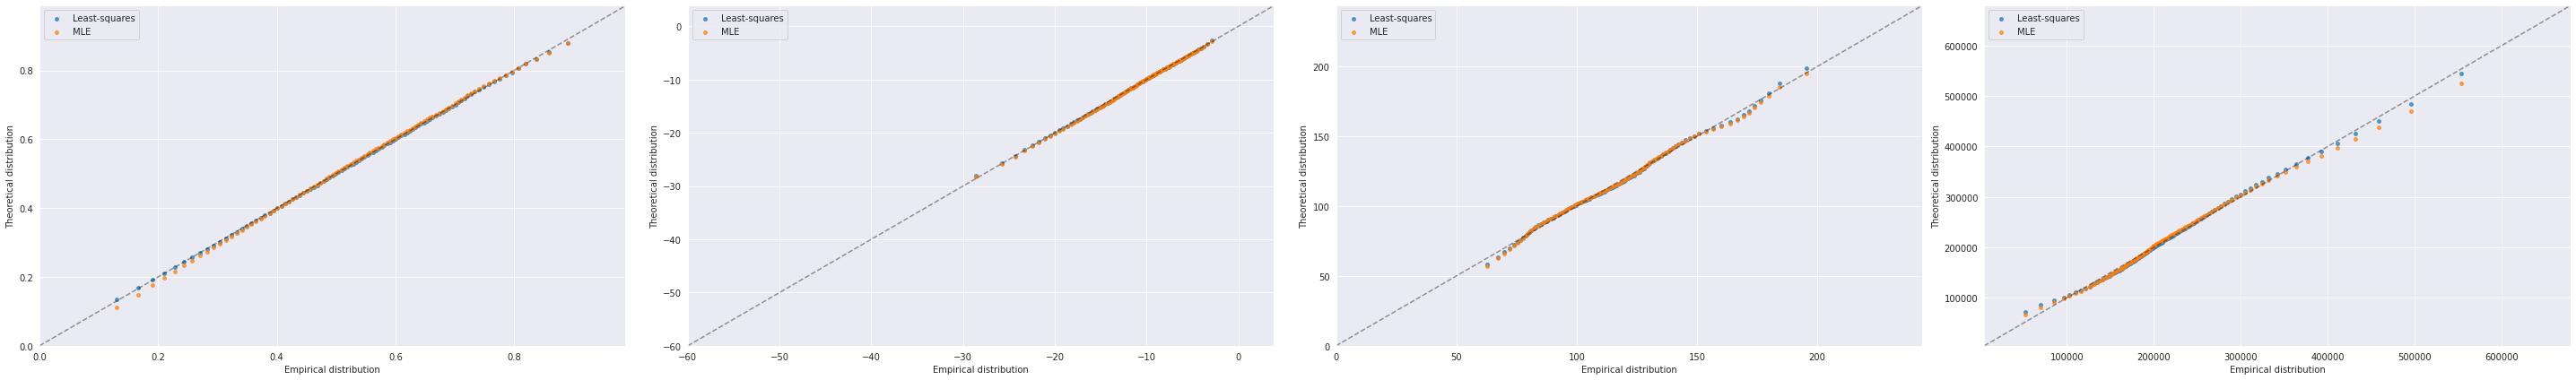

In [17]:
f, axs = plt.subplots(1, 4, figsize=(40, 6))

for ind, RV in enumerate(RVs):
    # Calculation of quantiles
    qn_theor_ls = MLE_dists[ind].ppf(percs / 100.0, *LS_fit_params[ind])
    qn_theor_mle = MLE_dists[ind].ppf(percs / 100.0, *MLE_fit_params[ind])
    
    axs[ind].scatter(qn_empir[ind], qn_theor_ls, s=15, alpha=0.7, label='Least-squares')
    axs[ind].scatter(qn_empir[ind], qn_theor_mle, s=15, alpha=0.7, label='MLE')
    line = np.linspace(source_df[RVs[ind]].min(), source_df[RVs[ind]].max(), 100)
    axs[ind].plot(line, line, alpha=0.4, color="k", ls="--")
    axs[ind].set_xlim(line.min(), line.max())
    axs[ind].set_ylim(line.min(), line.max())
    axs[ind].set_xlabel(f'Empirical distribution')
    axs[ind].set_ylabel('Theoretical distribution')
    axs[ind].legend()
    
plt.tight_layout()
plt.show()

#### Demonstrating distributions on plots

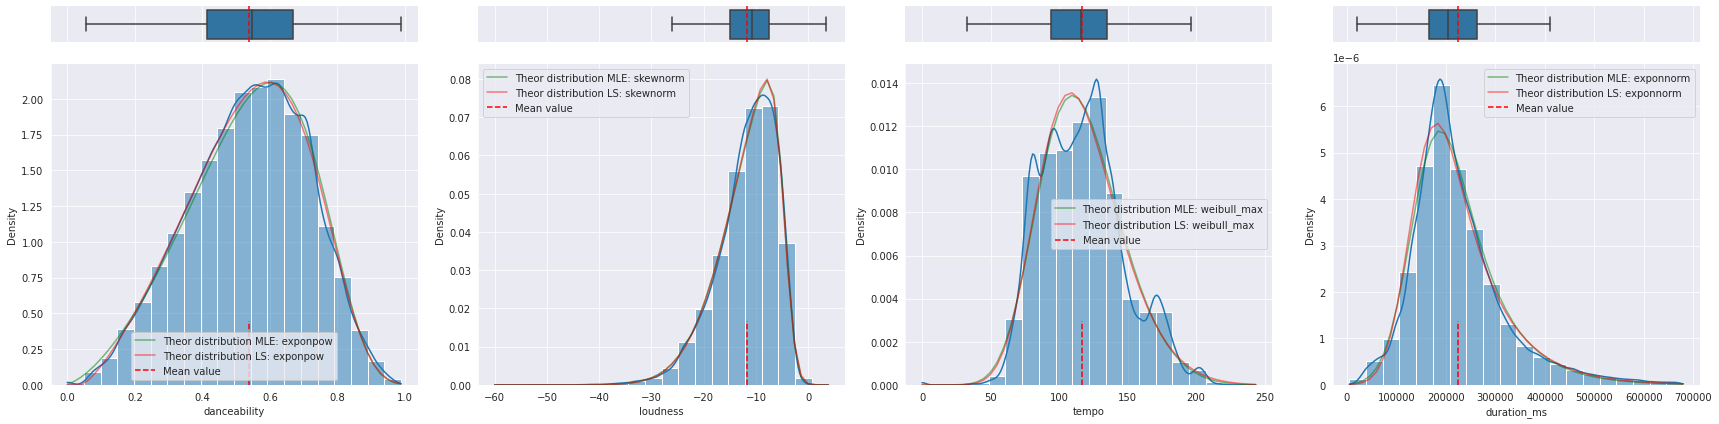

In [18]:
sns.set_style('darkgrid')

f, axs = plt.subplots(2, 4, gridspec_kw={"height_ratios": (.1, .9)}, sharex='col', figsize=(24, 6))

for ind, RV in enumerate(RVs):
    x = source_df[RV]
    pdf_MLE = MLE_dists[ind].pdf(np.linspace(x.min(), x.max()), *MLE_fit_params[ind])
    pdf_LS = MLE_dists[ind].pdf(np.linspace(x.min(), x.max()), *LS_fit_params[ind])
    
    ax_box = axs[0][ind]
    ax_dist = axs[1][ind]
    
    sns.boxplot(x, ax=ax_box, showfliers=False)
    sns.histplot(data=x, bins=20, kde=True, stat='density', ax=ax_dist)
    bounds = np.linspace(x.min(), x.max())
    ax_dist.plot(bounds, pdf_MLE, 'g', alpha=0.5, label=f'Theor distribution MLE: {MLE_dists[ind].name}')
    ax_dist.plot(bounds, pdf_LS, 'r', alpha=0.5, label=f'Theor distribution LS: {MLE_dists[ind].name}')
    ax_dist.axvline(x=x.mean(), color='r', ymax=0.2, linestyle='--', label='Mean value')
    ax_box.axvline(x=x.mean(), color='r', ymax=1, linestyle='--', label='Mean value')

    plt.setp(ax_box, xlabel='')
    ax_box.set(yticks=[])
    ax_dist.legend()
    sns.despine(ax=ax_dist)
    sns.despine(ax=ax_box, left=True)
    
plt.tight_layout()

#### Estimation of correctness of fitted distributions

In [19]:
def ks_test(data, distribution, params, alpha = 0.05, N = 100):
    ks = stats.kstest(data, distribution, params, N)
    if ks[1] > alpha:
        print(f"Kolmogorov test passed. Hypothesis about {distribution} is true")
        print(ks)
    else:
        print(f"Kolmogorov test failed. Hypothesis about {distribution} is false")
        print(ks)
    
def cvm_test(data, distribution, params, alpha = 0.05):
    cvm = stats.cramervonmises(data, distribution, params)
    if cvm.pvalue > alpha: 
        print(f"Cramer-von-mises test passed. Hypothesis about {distribution} is true")
        print(cvm)
    else:
        print(f"Cramer-von-mises test failed. Hypothesis about {distribution} is false")
        print(cvm)

In [20]:
# Calculation of the Kolmogorov-Smirnov and Cramér-von Mises tests for goodness of fit

for ind, RV in enumerate(RVs):
    print(RV + ':')
    ks_test(source_df[RV].dropna(), MLE_dists[ind].name, MLE_fit_params[ind])
    cvm_test(source_df[RV].dropna(), MLE_dists[ind].name, MLE_fit_params[ind])
    print()

danceability:
Kolmogorov test failed. Hypothesis about exponpow is false
KstestResult(statistic=0.011675483826309119, pvalue=4.45455316775016e-21)
Cramer-von-mises test failed. Hypothesis about exponpow is false
CramerVonMisesResult(statistic=7.03211333924617, pvalue=2.130927656551762e-10)

loudness:
Kolmogorov test failed. Hypothesis about skewnorm is false
KstestResult(statistic=0.00966338672068523, pvalue=1.423342906179094e-14)
Cramer-von-mises test failed. Hypothesis about skewnorm is false
CramerVonMisesResult(statistic=5.733298783182607, pvalue=6.718565703778268e-10)

tempo:
Kolmogorov test failed. Hypothesis about weibull_max is false
KstestResult(statistic=0.021580387464138984, pvalue=5.5577907700459545e-71)
Cramer-von-mises test failed. Hypothesis about weibull_max is false
CramerVonMisesResult(statistic=31.01436667636806, pvalue=1.0185207122148654e-08)

duration_ms:
Kolmogorov test failed. Hypothesis about exponnorm is false
KstestResult(statistic=0.021870944305529577, pvalue

So, according to tests we have evidence to **reject** the hypothesis that distributions are equal with the significance level 𝛼 = 0.05.